In [12]:
import numpy as np
from itertools import product
from scipy.special import comb
from tqdm.auto import tqdm
from scipy.stats import entropy
import seaborn as sns
import matplotlib.pyplot as plt
from more_itertools import set_partitions

# Figure 9: Deterministic EBIM Solver vs. Shkel et al. (2017)

### Deterministic EBIM Solver:

In [13]:
def merge_columns(matrix, indices):
    # Calculate the sum of columns corresponding to the indices
    summed_column = np.sum(matrix[:, indices], axis=1)

    # Remove the original columns specified by the indices
    matrix = np.delete(matrix, indices, axis=1)

    # Append the summed column to the right of the matrix
    return np.hstack((matrix, summed_column[:, np.newaxis]))

def search_functional_mapping(Px, R):
    Pxt = np.diag(Px)
    
    # if R >= H(x) return Px diag
    if R >= entropy(Px, base=2):
        return Pxt
    
    for i in range(1, len(Px)):
        # merging smallests
        two_smallest_cols = np.argsort(Pxt.sum(axis=0))[:2]
        Ps = merge_columns(Pxt, two_smallest_cols)
        Is = entropy(Ps.sum(axis=0), base=2)
        
        # merging largests
        two_largest_cols = np.argsort(Pxt.sum(axis=0))[-2:]
        Pl = merge_columns(Pxt, two_largest_cols)
        Il = entropy(Pl.sum(axis=0), base=2)

        if Is <= R:
            return Ps
        elif Il <= R < Is:
            return Pl
        else:
            Pxt = Pl

### Shkel et al. (2017): A single-shot approach to lossy source coding under logarithmic loss.

In [14]:
def shkel(Px, M):
    """ M: Alphabet size of T. """
    Px = np.sort(Px)[::-1]
    Pxt = np.zeros((len(Px), M))
    np.fill_diagonal(Pxt, Px)
    for i in np.arange(M, len(Px)):
        smallest_col = np.argmin(Pxt.sum(axis=0))
        Pxt[i, smallest_col] = Px[i]

    return Pxt

### Plot

In [15]:
def plot_R_I(Px, ax=None):
    Hx = entropy(Px, base=2)

    R_range = np.arange(0, Hx, 0.01)
    I_mine = []
    for R in R_range:
        Pxt = search_functional_mapping(Px, R)
        I = entropy(Pxt.sum(axis=0), base=2)
        I_mine.append(I)

    M_range = np.arange(1, len(Px)+1)
    I_yanina = []
    for M in M_range:
        Pxt = shkel(Px, M)
        I = entropy(Pxt.sum(axis=0), base=2)
        I_yanina.append(I)

    if ax is None:
        _, ax = plt.subplots(figsize=(6, 6))

    ax.step(R_range, I_mine, where='post', label='Ours', color='C0', lw=2, zorder=10)

    # p2 = np.sort(Px)[-2]
    # hp2 = entropy([p2, 1-p2], base=2)
    # ax.step(R_range, I_mine+hp2, where='post', label='I^*', color='C0')

    ax.step(np.log2(M_range), I_yanina, where='post', label='Shkel, et al. (2017)', color='C1', lw=2)

    gridcolor = ax.get_xgridlines()[0].get_color()
    ax.plot([0, Hx], [0, Hx], c=gridcolor, lw=1)
    ax.legend()
    # ax.grid()
    ax.set(xlabel='Rate', ylabel='Mutual Information', xlim=(0, Hx), ylim=(0, Hx))
    ax.set_aspect('equal', adjustable='box')

    return ax


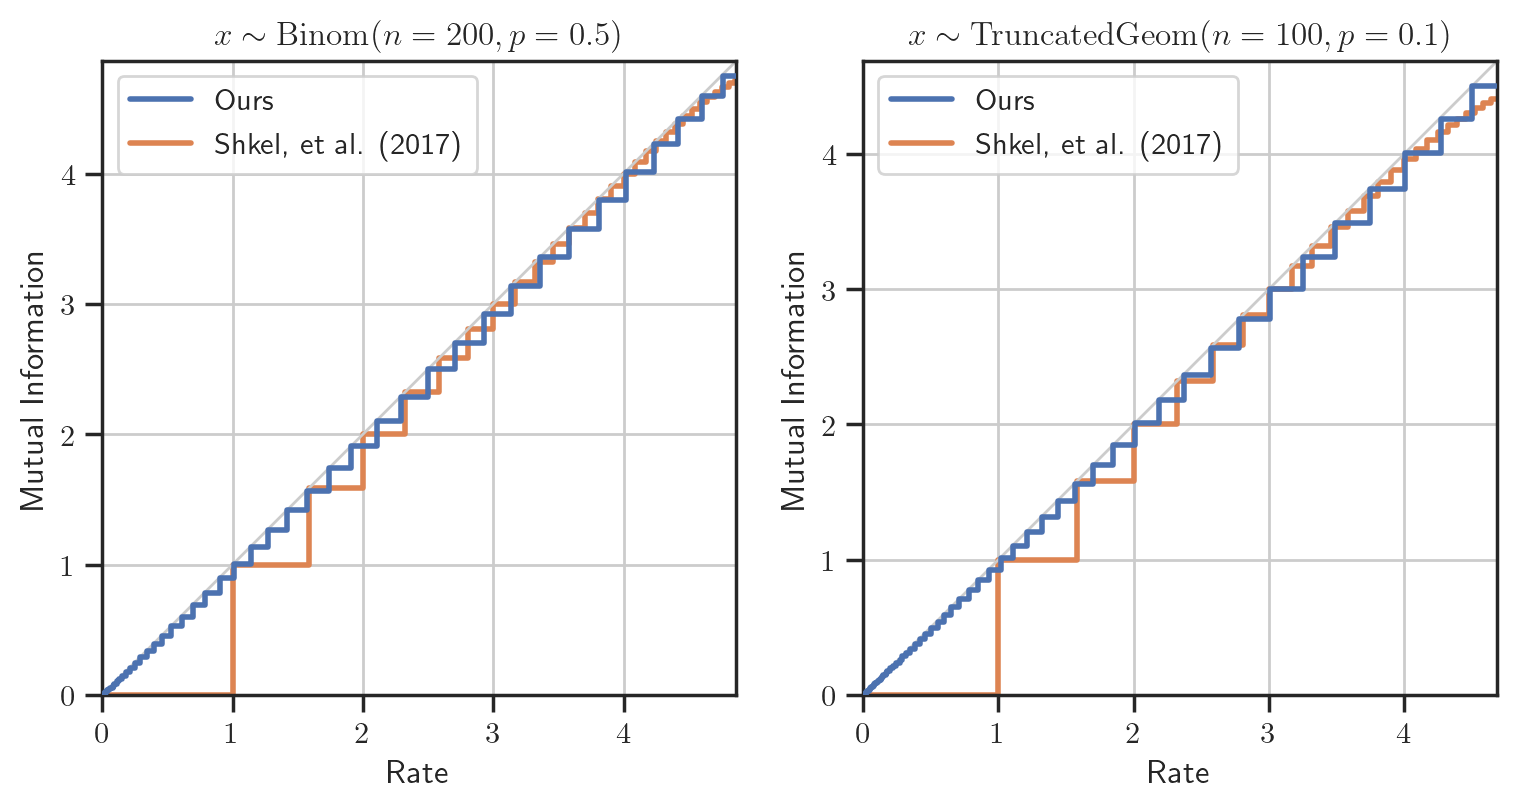

In [16]:
from scipy.stats import binom, geom

sns.set_theme()
sns.set_style("ticks")
sns.set_context("notebook")
plt.rcParams['text.usetex'] = True

fig, axs = plt.subplots(1, 2, figsize=(9, 4.5), dpi=200, gridspec_kw = {'wspace':.2, 'hspace':0})
axs = axs.flat

# binom
N = 200
p = 0.5
Px = binom.pmf(np.arange(N), N-1, p)
plot_R_I(Px, axs[0])
axs[0].set_title(r'$x \sim \textrm{Binom}(n=200, p=0.5)$')
axs[0].grid()

# geom
p = 0.1
N = 100
Px = geom.pmf(np.arange(N), p)
plot_R_I(Px, axs[1])
axs[1].set_title(r'$x \sim \textrm{TruncatedGeom}(n=100, p=0.1)$')
axs[1].grid()
